In [20]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use("dark_background")

# data preparation
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical # np_utils

# building model 1
from tensorflow.keras.models import Sequential # Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam  

# additions for model 2
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD

# additions for model 3
from tensorflow.keras.layers import GlobalAveragePooling2D

# additions for model 4 (needs scipy to be installed in env)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# additions for model 5
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop

print(tf.__version__)

2.3.1


## Import data

In [2]:
(train_images, y_train), (test_images, y_test) = cifar10.load_data()
print(train_images.shape, y_train.shape, test_images.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

# Normalize pixel values to be between 0 and 1
X_train, X_test = train_images / 255.0, test_images / 255.0

print(X_train.shape, y_train.shape, Y_train.shape,
      X_test.shape, y_test.shape, Y_test.shape)

(50000, 32, 32, 3) (50000, 1) (50000, 10) (10000, 32, 32, 3) (10000, 1) (10000, 10)


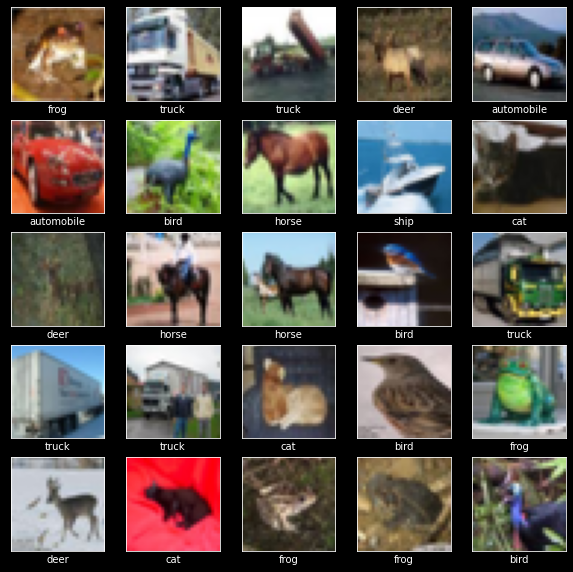

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [5]:
size = 32
channels = 3
num_classes = 10

In [6]:
def show_fit_history(h):
    fig, ax = plt.subplots(figsize=(14,4))
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(h.history['loss'], color='blue', label='train')
    plt.plot(h.history['val_loss'], color='orange', label='test')
    plt.legend(['train', 'test'])


    plt.subplot(122)
    plt.title('Error rate')
    plt.plot(1.0-np.array(h.history['accuray']), color='blue', label='train')
    plt.plot(1.0-np.array(h.history['val_accuray']), color='orange', label='test')
    plt.legend(['train', 'test'])
    plt.grid(True)
    plt.show()
    pass

## First simple CNN, 1.2 M params (79 - 80 % accuracy)

In [7]:
model = Sequential()
    
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(size,size,channels)))    
model.add(Conv2D(32, (3, 3), activation='relu'))    
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))    
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
    
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(num_classes, activation='softmax'))
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [8]:
model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer=Adam(lr=1.0e-4), # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy']) # Metrics to be evaluated by the model

In [9]:
h1 = model.fit(X_train, Y_train,
               batch_size = 128, # number of samples per gradient update
               epochs = 100, # number of iterations
               validation_data= (X_test, Y_test),
               verbose=1)

Epoch 1/100
168/391 [===========>..................] - ETA: 38s - loss: 2.1683 - accuracy: 0.1899

KeyboardInterrupt: 

> 79.630


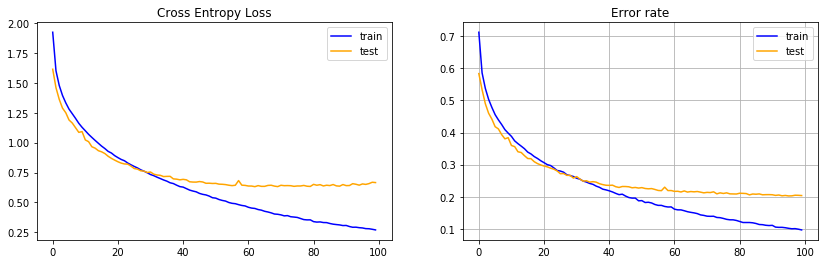

In [20]:
_, acc = model.evaluate(X_test, Y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

show_fit_history(h1)

## Second CNN, 2.2 M params (82.0 - 82.5 % accuracy)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(size,size,channels)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
 

model.add(Dense(10))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)       

In [11]:
NUM_EPOCHS = 40
INIT_LR = 1e-2
BS = 32
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
h2 = model.fit(X_train, Y_train, epochs=NUM_EPOCHS, batch_size=BS, 
               validation_data=(X_test, Y_test), verbose=1)
_, acc = model.evaluate(X_test, Y_test, verbose=0)
print('> %.3f' % (acc * 100.0))
#model.save_weights('mnist_CNN_2.h5')

show_fit_history(h2)

Epoch 1/40
  70/1563 [>.............................] - ETA: 2:25 - loss: 2.9350 - accuracy: 0.2366

KeyboardInterrupt: 

## Third model, 1.4 M params, pure CNN, no DA (should reach 84.5 - 85.0% accuracy)

In [13]:
model = Sequential()
    
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(size,size,channels)))    
model.add(Dropout(0.2))
    
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
model.add(Dropout(0.5))
    
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
model.add(Dropout(0.5))    
    
model.add(Conv2D(192, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(192, (1, 1),padding='valid'))
model.add(Activation('relu'))
model.add(Conv2D(10, (1, 1), padding='valid'))

model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 192)      

In [14]:
model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer=Adam(lr=1.0e-4), # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy']) # Metrics to be evaluated by the model

In [ ]:
h3 = model.fit(X_train, Y_train,
               batch_size = 128, epochs = 100, # number of iterations
               validation_data= (X_test, Y_test), verbose=1)

> 81.300


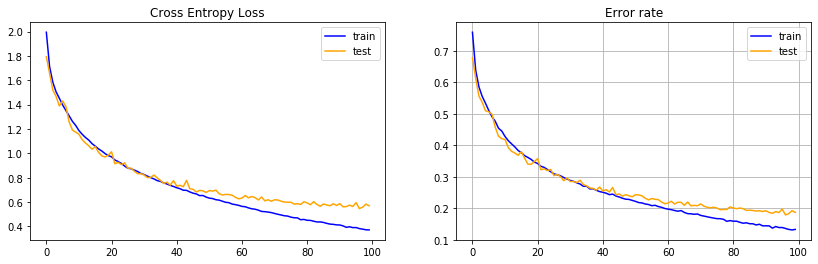

In [35]:
_, acc = model.evaluate(X_test, Y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

show_fit_history(h3)

In [ ]:
h3bis = model.fit(X_train, Y_train,
                  batch_size = 128, initial_epoch=100, epochs = 200, # number of iterations
                  validation_data= (X_test, Y_test), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 101/200
50000/50000 [==============================] - 37s 740us/step - loss: 0.3652 - acc: 0.8713 - val_loss: 0.5605 - val_acc: 0.8216
Epoch 102/200
50000/50000 [==============================] - 37s 741us/step - loss: 0.3690 - acc: 0.8696 - val_loss: 0.5699 - val_acc: 0.8142
Epoch 103/200
50000/50000 [==============================] - 37s 744us/step - loss: 0.3627 - acc: 0.8721 - val_loss: 0.5715 - val_acc: 0.8177
Epoch 104/200
50000/50000 [==============================] - 37s 740us/step - loss: 0.3583 - acc: 0.8738 - val_loss: 0.5578 - val_acc: 0.8178
Epoch 105/200
50000/50000 [==============================] - 37s 743us/step - loss: 0.3486 - acc: 0.8753 - val_loss: 0.5465 - val_acc: 0.8230
Epoch 106/200
50000/50000 [==============================] - 37s 740us/step - loss: 0.3507 - acc: 0.8752 - val_loss: 0.5557 - val_acc: 0.8193
Epoch 107/200
50000/50000 [==============================] - 41s 814us/step - loss: 0.3439 - acc: 

> 84.500


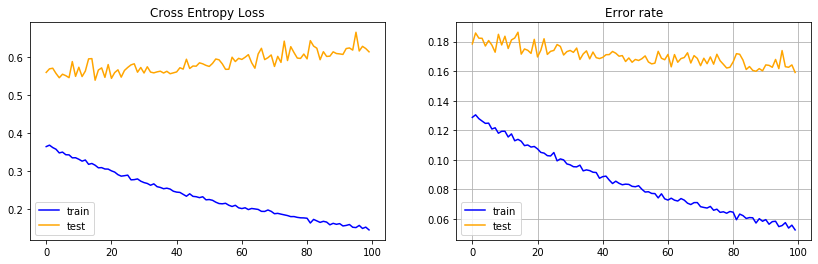

In [40]:
_, acc = model.evaluate(images_test, class_test, verbose=0)
print('> %.3f' % (acc * 100.0))

show_fit_history(h3bis)

In [ ]:
h3ter = model.fit(images_train, class_train,
                  batch_size = 128, initial_epoch=200, epochs = 300, # number of iterations
                  validation_data= (images_test, class_test), verbose=1)

> 84.500


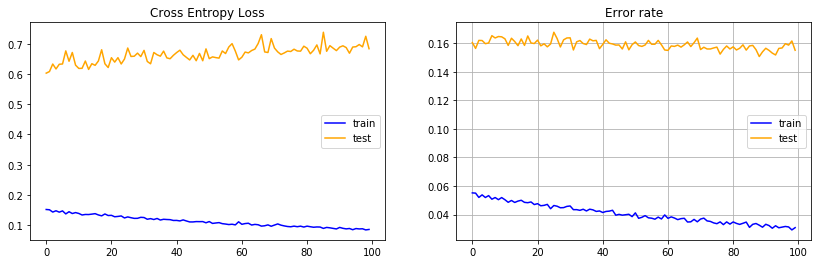

In [41]:
_, acc = model.evaluate(images_test, class_test, verbose=0)
print('> %.3f' % (acc * 100.0))

show_fit_history(h3ter)

## Same with data augmentation (87 - 88% accuracy)

In [7]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [8]:
model = Sequential()
    
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(size,size,channels)))    
model.add(Dropout(0.2))
    
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
model.add(Dropout(0.5))
    
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
model.add(Dropout(0.5))    
    
model.add(Conv2D(192, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(192, (1, 1),padding='valid'))
model.add(Activation('relu'))
model.add(Conv2D(10, (1, 1), padding='valid'))

model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       3

In [9]:
model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer=Adam(lr=1.0e-4), # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy']) # Metrics to be evaluated by the model

In [10]:
h4 = model.fit(datagen.flow(X_train, Y_train, batch_size = 32),
               steps_per_epoch = len(X_train) / 32, # number of samples per gradient update
               epochs = 200, # number of iterations
               validation_data= (X_test, Y_test), verbose=1)

Epoch 1/200
  65/1562 [>.............................] - ETA: 7:32 - loss: 2.2984 - accuracy: 0.1082

KeyboardInterrupt: 

> 86.280


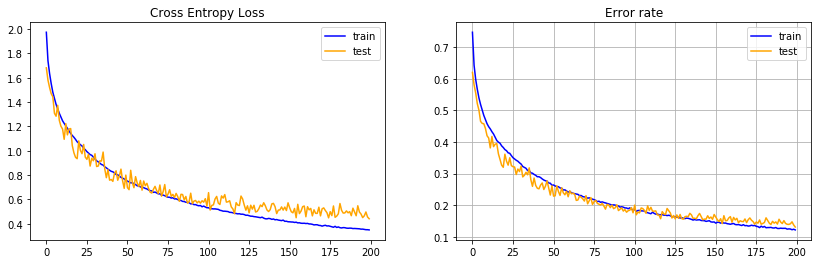

In [33]:
_, acc = model.evaluate(X_test, Y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

show_fit_history(h4)

In [34]:
h4bis = model.fit(datagen.flow(X_train, Y_train, batch_size = 32),
                  steps_per_epoch = len(X_train) / 32, # number of samples per gradient update
                  initial_epoch=200, epochs = 400, # number of iterations
                  validation_data= (X_test, Y_test), verbose=1)

Epoch 201/400
1563/1562 [==============================] - 24s 15ms/step - loss: 0.3384 - acc: 0.8812 - val_loss: 0.4612 - val_acc: 0.8632
Epoch 202/400
1563/1562 [==============================] - 25s 16ms/step - loss: 0.3420 - acc: 0.8811 - val_loss: 0.4615 - val_acc: 0.8619
Epoch 203/400
1563/1562 [==============================] - 25s 16ms/step - loss: 0.3417 - acc: 0.8807 - val_loss: 0.4667 - val_acc: 0.8642
Epoch 204/400
1563/1562 [==============================] - 25s 16ms/step - loss: 0.3416 - acc: 0.8800 - val_loss: 0.5330 - val_acc: 0.8500
Epoch 205/400
1563/1562 [==============================] - 25s 16ms/step - loss: 0.3423 - acc: 0.8785 - val_loss: 0.4973 - val_acc: 0.8538
Epoch 206/400
1563/1562 [==============================] - 25s 16ms/step - loss: 0.3387 - acc: 0.8812 - val_loss: 0.4485 - val_acc: 0.8675
Epoch 207/400
1563/1562 [==============================] - 25s 16ms/step - loss: 0.3362 - acc: 0.8814 - val_loss: 0.4552 - val_acc: 0.8632
Epoch 208/400
1563/1562 [==

> 86.570


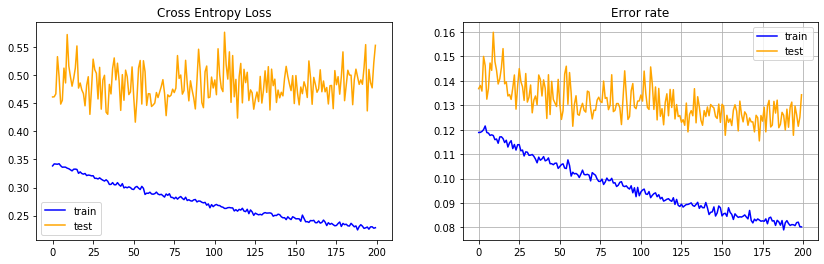

In [35]:
_, acc = model.evaluate(X_test, X_test, verbose=0)
print('> %.3f' % (acc * 100.0))

show_fit_history(h4bis)

## Alternative with 300K params and fine tuning of the LR to reach 90%
https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/

In [12]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    if epoch > 150:
        lrate = 0.0001
    if epoch > 200:
        lrate = 0.00005
    return lrate

In [13]:
#z-score
mean = np.mean(X_train,axis=(0,1,2,3))
std = np.std(X_train,axis=(0,1,2,3))
Xnorm_train = (X_train-mean)/(std+1e-7)
Xnorm_test = (X_test-mean)/(std+1e-7)

In [16]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay), 
                 input_shape=Xnorm_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)       

In [17]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(Xnorm_train)

In [21]:
#training
batch_size = 64
 
opt_rms = RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
h5 = model.fit(datagen.flow(Xnorm_train, Y_train, batch_size=batch_size),
               steps_per_epoch=Xnorm_train.shape[0] // batch_size, epochs=125,
               verbose=1,validation_data=(Xnorm_test, Y_test),
               callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/125
 88/781 [==>...........................] - ETA: 2:27 - loss: 2.7886 - accuracy: 0.2658

KeyboardInterrupt: 

> 88.110


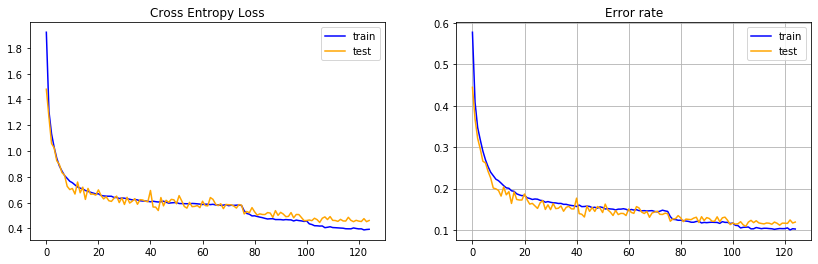

In [43]:
_, acc = model.evaluate(Xnorm_test, Y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

show_fit_history(h5)

In [45]:
h5bis = model.fit(datagen.flow(Xnorm_train, Y_train, batch_size=batch_size),
                  steps_per_epoch=Xnorm_train.shape[0] // batch_size, initial_epoch=125, epochs = 200,
                  verbose=1, validation_data=(Xnorm_test, Y_test),
                  callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 126/200
781/781 [==============================] - 24s 31ms/step - loss: 0.3949 - acc: 0.8966 - val_loss: 0.4189 - val_acc: 0.8907
Epoch 127/200
781/781 [==============================] - 24s 30ms/step - loss: 0.3969 - acc: 0.8965 - val_loss: 0.4461 - val_acc: 0.8862
Epoch 128/200
781/781 [==============================] - 24s 31ms/step - loss: 0.3925 - acc: 0.8984 - val_loss: 0.4530 - val_acc: 0.8836
Epoch 129/200
781/781 [==============================] - 24s 30ms/step - loss: 0.3955 - acc: 0.8971 - val_loss: 0.4288 - val_acc: 0.8904
Epoch 130/200
781/781 [==============================] - 23s 30ms/step - loss: 0.3898 - acc: 0.8981 - val_loss: 0.4323 - val_acc: 0.8896
Epoch 131/200
781/781 [==============================] - 23s 29ms/step - loss: 0.3886 - acc: 0.8988 - val_loss: 0.4311 - val_acc: 0.8913
Epoch 132/200
781/781 [==============================] - 25s 31ms/step - loss: 0.3917 - acc: 0.8982 - val_loss: 0.4427 - val_acc: 0.8862
Epoch 133/200
781/781 [==================

> 89.710


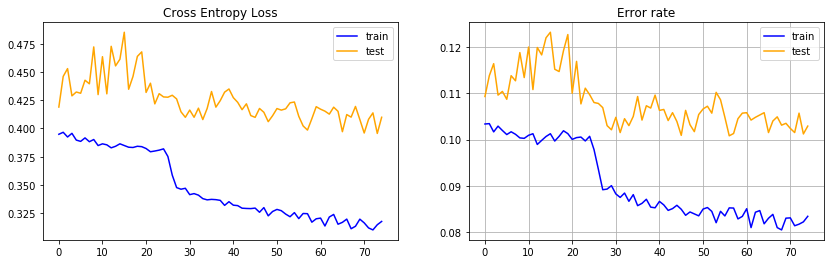

In [46]:
_, acc = model.evaluate(Xnorm_test, Y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

show_fit_history(h5bis)

In [48]:
h5ter = model.fit(datagen.flow(Xnorm_train, Y_train, batch_size=batch_size),
                  steps_per_epoch=x_train.shape[0] // batch_size, initial_epoch=200, epochs = 250,
                  verbose=1, validation_data=(Xnorm_test, Y_test),
                  callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 201/250
781/781 [==============================] - 23s 30ms/step - loss: 0.3144 - acc: 0.9178 - val_loss: 0.4176 - val_acc: 0.8938
Epoch 202/250
781/781 [==============================] - 22s 28ms/step - loss: 0.3073 - acc: 0.9191 - val_loss: 0.4026 - val_acc: 0.8985
Epoch 203/250
781/781 [==============================] - 24s 30ms/step - loss: 0.3075 - acc: 0.9210 - val_loss: 0.3990 - val_acc: 0.8966
Epoch 204/250
781/781 [==============================] - 23s 30ms/step - loss: 0.3009 - acc: 0.9221 - val_loss: 0.3978 - val_acc: 0.8989
Epoch 205/250
781/781 [==============================] - 24s 31ms/step - loss: 0.3078 - acc: 0.9208 - val_loss: 0.3972 - val_acc: 0.8984
Epoch 206/250
781/781 [==============================] - 23s 29ms/step - loss: 0.3039 - acc: 0.9221 - val_loss: 0.3938 - val_acc: 0.9010
Epoch 207/250
781/781 [==============================] - 24s 31ms/step - loss: 0.3022 - acc: 0.9221 - val_loss: 0.4032 - val_acc: 0.8975
Epoch 208/250
781/781 [==================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



781/781 [==============================] - 24s 30ms/step - loss: 0.2839 - acc: 0.9261 - val_loss: 0.3962 - val_acc: 0.8985
Epoch 250/250
781/781 [==============================] - 24s 30ms/step - loss: 0.2932 - acc: 0.9236 - val_loss: 0.3835 - val_acc: 0.9010


> 90.100


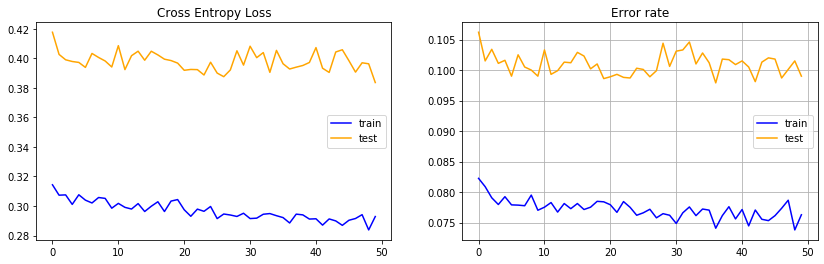

In [51]:
_, acc = model.evaluate(Xnorm_test, Y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

show_fit_history(h5ter)